# Projeto Marinha do Brasil

# Autor: Natanael Junior (natmourajr@gmail.com)
# Laboratorio de Processamento de Sinais - UFRJ

In [1]:
import os
import pickle
import numpy as np
import time

from sklearn.decomposition import PCA
from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'NeuralNetwork'
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

pict_results_path = results_path+'/'+analysis_name+'/picts'
files_results_path = results_path+'/'+analysis_name+'/output_files'

# Read data
# Check if LofarData has created...
m_time = time.time()

database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = True
development_events = 100

if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
    
    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)


    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:], 
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)
        
    all_data = balanced_data
    all_trgt = balanced_trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

KeyboardInterrupt: 

# Train process
## The train will modify one file and create three different files

### Log File:
This file will store basic information of all Package's trains and it will guide the analyses file to recognize which train information file should load. In each train this file should be appended with a new line contend the basic information to find the train information file (TXT FORMAT) or (PYTHON FORMAT) - This file should be access by all programs (MatLab and Python) for Analysis

### Train Information File
This file will store full information of the train performed (all parameters) in its name (each train information file will have a different name). And it will guide which train classifier file or which train result file should be open for analysis (TXT FORMAT) or (PYTHON FORMAT) - This file should be access by all programs (MatLab and Python) for Analysis

### Train Result File
This file will store the classifier result for all data and classification target (TXT FORMAT) or (PYTHON FORMAT) - This file should be access by all programs (MatLab and Python) for Analysis


In [ ]:
%time

from sklearn import cross_validation
from Functions import LogFunctions as log

# Create a entry in log file
m_log = log.LogInformation()
date = m_log.CreateLogEntry("Classification",'NeuralNetwork')

# Create a train information file
n_folds = 2
n_inits = 2
norm = 'mapstd'

train_info = {}
train_info['n_folds'] = n_folds
train_info['n_inits'] = n_inits
train_info['norm'] = norm

# divide data in train and test for novelty detection
print 'Dividing data in trn and tst'
CVO = cross_validation.StratifiedKFold(all_trgt, n_folds)
CVO = list(CVO)
train_info['CVO'] = CVO

train_info['preprocessing_extraction_done'] = False
train_info['preprocessing_analysis_done'] = False
train_info['train_done'] = False
train_info['results_done'] = False
train_info['dev'] = development_flag

train_info_name = files_results_path+'/'+date+'_train_info.jbl'
joblib.dump([train_info],train_info_name,compress=9)

In [ ]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries(package_name="Classification")
print log_entries

In [ ]:
# Read Information of Train Info File
choose_date = '2017_07_04_18_37_57'

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'NeuralNetwork':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'Analysing train performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = files_results_path+'/'+date+'_train_info.jbl'
    [train_info] = joblib.load(train_info_name)
    print 'NeuralNetwork Train Info File'
    print 'Date: %s'%(choose_date)
    print 'Number of Folds: %i'%(train_info['n_folds'])
    print 'Number of Inits: %i'%(train_info['n_inits'])
    print 'Normalization Method: %s'%(train_info['norm'])
    if train_info['preprocessing_extraction_done']:
        print 'Preprocessing Extraction Done: True'
    else:
        print 'Preprocessing Extraction Done: False'
    if train_info['preprocessing_analysis_done']:
        print 'Preprocessing Analysis Done: True'
    else:
        print 'Preprocessing Analysis Done: False'
    if train_info['train_done']:
        print 'Train Done: True'
    else:
        print 'Train Done: False'
    if train_info['results_done']:
        print 'Extract Results: True'
    else:
        print 'Extract Results: False'

In [ ]:
# Train Process
from Functions import LogFunctions as log
from sklearn import cross_validation
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils

from datetime import datetime  
from datetime import timedelta 

train_info_name = files_results_path+'/'+choose_date+'_train_info.jbl'
[train_info] = joblib.load(train_info_name)

# try to estimate time to be done...
total_trains = train_info['n_folds']*train_info['n_inits']
nn_trained = 0 

n_neurons = 10

for ifold in range(train_info['n_folds']):
    train_id, test_id = CVO[ifold]
    
    classifiers = []
    trn_desc = {}

    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
    norm_all_data = scaler.transform(all_data)
       
    print 'Train Process for %i Fold of %i Folds'%(ifold+1,train_info['n_folds'] )
    
    best_init = 0
    best_loss = 999
    
    for i_init in range(train_info['n_inits']):
        print 'Init: %i of %i'%(i_init+1,train_info['n_inits'])
        model = Sequential()
        model.add(Dense(n_neurons, input_dim=all_data.shape[1], init="uniform"))
        model.add(Activation('tanh'))
        model.add(Dense(trgt_sparse.shape[1], init="uniform")) 
        model.add(Activation('tanh'))

        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='mean_squared_error', optimizer=sgd
                      ,metrics=['accuracy'])

        # Train model
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                            verbose=0, mode='auto')
        start_time = time.time()
        init_trn_desc = model.fit(norm_all_data[train_id], trgt_sparse[train_id], 
                                nb_epoch=3, 
                                batch_size=256,
                                callbacks=[earlyStopping], 
                                verbose=1,
                                validation_data=(all_data[test_id],trgt_sparse[test_id]),
                                shuffle=True)
        end_time = time.time()
        train_time = end_time -start_time
        nn_trained += 1
        
        now = datetime.now()
        finish_time  = now + timedelta(seconds = (total_trains-nn_trained)*train_time)
        
        print 'Estimated Finish Time: %s'%(
        finish_time.strftime("%Y/%m/%d-%H:%M:%S"))
        if np.min(init_trn_desc.history['val_loss']) < best_loss:
            best_init = i_init
            best_loss = np.min(init_trn_desc.history['val_loss'])
            classifiers = model
            trn_desc['epochs'] = init_trn_desc.epoch
            trn_desc['acc'] = init_trn_desc.history['acc']
            trn_desc['loss'] = init_trn_desc.history['loss']
            trn_desc['val_loss'] = init_trn_desc.history['val_loss']
            trn_desc['val_acc'] = init_trn_desc.history['val_acc']
            
    # save model
    base_name = files_results_path+'/'+date+'_'
    save_file_name = base_name+"_fold_%i_classifier.h5"%(ifold)
    classifiers.save(save_file_name)
    save_file_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
    joblib.dump([train_info,n_neurons,trn_desc],save_file_name,compress=9)
    
    train_info['train_done'] = True
    train_info_name = files_results_path+'/'+date+'_train_info.jbl'
    joblib.dump([train_info],train_info_name,compress=9)

In [ ]:
# plot train updates
import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

fig1 = plt.figure(figsize=(10,6))

choose_date = '2017_07_04_18_23_07'
ifold = 0

base_name = files_results_path+'/'+choose_date+'_'

load_file_name = base_name+"fold_%i_trn_desc.jbl"%(ifold)
[train_info,n_neurons,trn_desc] = joblib.load(load_file_name)

# load weights into new model
from keras.models import load_model
load_file_name = base_name+"fold_%i_classifier.h5"%(ifold)
model = load_model(load_file_name)

l1 = plt.plot(trn_desc['epochs'],
              trn_desc['loss'],color=[0,0,1],
              linewidth=2.5,linestyle='solid',label='Train Perf.')
l2 = plt.plot(trn_desc['epochs'],
              trn_desc['val_loss'],color=[1,0,0],
              linewidth=2.5,linestyle='dashed',label='Test Perf.')
cost = ''
if model.loss == 'mean_squared_error':
    cost = 'MSE'

plt.grid(True)
plt.xlabel("# Epochs",fontsize=18,fontweight='bold')
plt.ylabel(cost,fontsize=18,fontweight='bold')
plt.title(cost+" vs #Epochs",fontsize=18,fontweight='bold')
plt.legend()

In [ ]:
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect(1)

from sklearn.metrics import confusion_matrix

labels = class_labels.values()

# read trained model
choose_date = '2017_07_04_18_23_07'
ifold = 0

base_name = files_results_path+'/'+choose_date+'_'

train_info_name = base_name+"fold_%i_trn_desc.jbl"%(ifold)
[train_info,n_neurons,trn_desc] = joblib.load(train_info_name)

ifold = 0
train_id, test_id = train_info['CVO'][ifold]
    
# normalize data based in train set
if train_info['norm'] == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
norm_all_data = scaler.transform(all_data)

from keras.models import load_model
load_file_name = base_name+"fold_%i_classifier.h5"%(ifold)
model = load_model(load_file_name)


output = model.predict(norm_all_data)
all_output = np.argmax(output,axis=1)
#confusion_matrix(trgt_sparse, output, labels=["ClassA", "ClassB", "ClassC","ClassD"])
cm = confusion_matrix(all_trgt[test_id], all_output[test_id])
cm_normalized = 100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
im =ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape

for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
fig.colorbar(im)
tick_marks = np.arange(len(labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)

labels = class_labels.values()

# read trained model
choose_date = '2017_07_04_18_23_07'
ifold = 0

base_name = files_results_path+'/'+choose_date+'_'

train_info_name = base_name+"fold_%i_trn_desc.jbl"%(ifold)
[train_info,n_neurons,trn_desc] = joblib.load(train_info_name)

# normalize data based in train set
if train_info['norm'] == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
norm_all_data = scaler.transform(all_data)

output = model.predict(norm_all_data)

from sklearn.neighbors import KernelDensity

m_bins = np.linspace(-0.5, 1.5, 50)

m_colors = ['b', 'r', 'g', 'y']

kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                    #'epanechnikov', 'exponential', 'linear', 'cosine'
for i_target in range(trgt_sparse.shape[1]):
    for i_output in range(output.shape[1]):
        subplot_id = output.shape[1]*i_target+i_output
        m_pts = output[all_trgt==i_target,i_output]
        
        n, bins, patches = ax[i_target,i_output].hist(m_pts,bins=m_bins,
                                                      fc=m_colors[i_target],
                                                      alpha=0.8, normed=1)
        
        if i_output == 0:
            ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                             fontweight='bold',fontsize=15)
        if i_target == 3:
            ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                             fontweight='bold',fontsize=15)
        ax[i_target,i_output].grid()
        

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)

labels = class_labels.values()

# read trained model
choose_date = '2017_07_04_16_31_28'
ifold = 0

base_name = files_results_path+'/'+choose_date+'_'

train_info_name = base_name+"fold_%i_trn_desc.jbl"%(ifold)
[train_info,n_neurons,trn_desc] = joblib.load(train_info_name)

# normalize data based in train set
if train_info['norm'] == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
norm_all_data = scaler.transform(all_data)

output = model.predict(norm_all_data)

from sklearn.neighbors import KernelDensity

m_bins = np.linspace(-0.5, 1.5,100)

m_colors = ['b', 'r', 'g', 'y']

kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                    #'epanechnikov', 'exponential', 'linear', 'cosine'
for i_target in range(trgt_sparse.shape[1]):
    for i_output in range(output.shape[1]):
        subplot_id = output.shape[1]*i_target+i_output
        m_pts = output[all_trgt==i_target,i_output]
        
        kde = KernelDensity(kernel=kernel,algorithm='auto',
                            bandwidth=0.5).fit(m_pts[:, np.newaxis])
        log_dens_x = kde.score_samples(m_bins[:, np.newaxis])
        ax[i_target,i_output].plot(m_bins, np.exp(log_dens_x),
                                   color=m_colors[i_target],linewidth=2.0)
        if i_output == 0:
            ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                             fontweight='bold',fontsize=15)
        if i_target == 3:
            ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                             fontweight='bold',fontsize=15)
        ax[i_target,i_output].grid()
        

In [ ]:
from Functions import LogFunctions as log

# Create a entry in log file
m_log = log.LogInformation()
#date = m_log.CreateLogEntry("Classification",'NeuralNetwork')
log_entries = m_log.RecoverLogEntries(package_name="Classification")
print log_entries

In [3]:
import os
import pickle
import numpy as np
import time

from sklearn.decomposition import PCA
from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'NeuralNetwork'
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

pict_results_path = results_path+'/'+analysis_name+'/picts'
files_results_path = results_path+'/'+analysis_name+'/output_files'

# Read data
# Check if LofarData has created...
m_time = time.time()

database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = True
development_events = 101

if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
    
    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)


    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:], 
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)
        
    all_data = balanced_data
    all_trgt = balanced_trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Time to import all libraries: 5.10215759277e-05 seconds
Time to read data file: 1.48441195488 seconds
Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events


NeuralClassication analysis analysis conf mat function


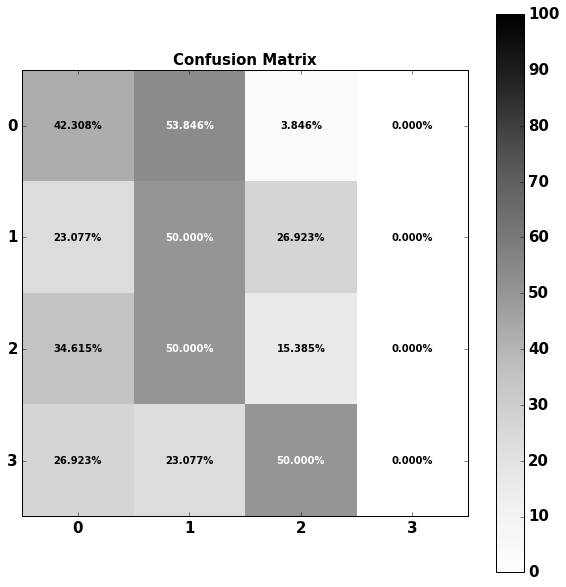

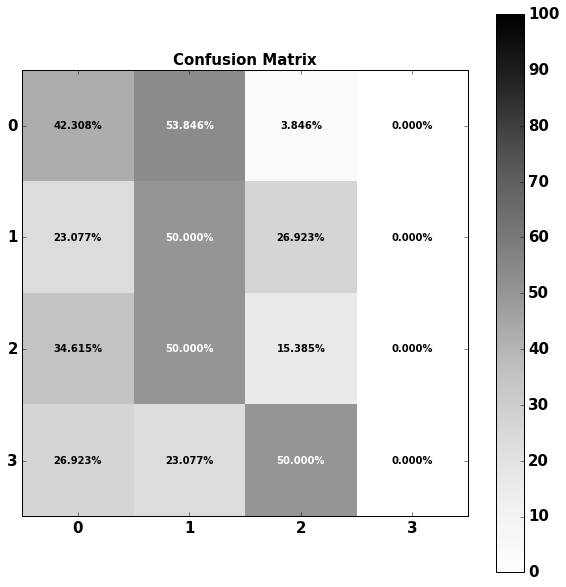

In [6]:
from Functions import ClassificationAnalysis as class_anal
a = class_anal.NeuralClassification(name='NeuralNetwork',
                                    preproc_path=files_results_path,
                                    train_path=files_results_path,
                                    anal_path=files_results_path)
date = '2017_07_06_11_55_40'
a.trn_info = class_anal.TrnInformation(date=date, n_folds=4, n_inits=1, n_epochs=3)
a.trn_info.SplitTrainSet(all_trgt)

%matplotlib inline  
#a.analysis_top_sweep(all_data,trgt_sparse,trn_info=a.trn_info, min_neurons=1, max_neurons=10)
#a.analysis_train(all_data,trgt_sparse,trn_info=a.trn_info, n_neurons=1, fold=0)
a.analysis_conf_mat(all_data,trgt_sparse,trn_info=a.trn_info, class_labels=class_labels, n_neurons=1, fold=0)


In [7]:
class_labels.items

<function items>